In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, copy, os, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
%matplotlib inline

In [2]:
data_path = 'synthetic_coffee_health_10000.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print("Loaded dataset from", data_path, "shape:", df.shape)
else:
    print("Dataset not found. Generating synthetic dataset (10,000 samples) for demonstration.")
    np.random.seed(42)
    N = 10000

    # Ідентифікатори та базові характеристики
    ids = np.arange(1, N+1)
    age = np.random.randint(18, 80, size=N)
    gender = np.random.choice(['Male', 'Female', 'Other'], size=N, p=[0.48, 0.48, 0.04])
    countries = np.random.choice(['USA','UK','France','Germany','India','Brazil','Kenya'], size=N)
    occupation = np.random.choice(['Student','Employed','Healthcare','Retired','Unemployed','Other'], size=N)

    # Кава, кофеїн, сон
    coffee_intake = np.clip(np.round(np.random.gamma(2.0, 1.2, size=N)), 0, 15)
    caffeine_mg = coffee_intake * np.random.normal(95, 10, size=N)
    sleep_hours = np.clip(np.random.normal(7, 1.5, size=N), 3, 10)
    sleep_quality = np.random.choice(['Poor','Average','Good'], size=N, p=[0.2,0.5,0.3])

    # Стрес, шкідливі звички, фізична активність
    stress_level = np.random.choice(['Low','Medium','High'], size=N, p=[0.4,0.4,0.2])
    smoking = np.random.choice(['Never','Former','Current'], size=N, p=[0.7,0.15,0.15])
    alcohol = np.random.choice(['None','Low','Moderate','High'], size=N, p=[0.2,0.5,0.25,0.05])
    bmi = np.round(np.random.normal(25, 4, size=N), 1)
    heart_rate = np.round(np.random.normal(72, 10, size=N)).astype(int)
    physical_activity = np.clip(np.round(np.random.exponential(1.5, size=N), 1), 0, 10)

    # 3. Генерація цільової змінної
    score = (
        (coffee_intake / 5.0) 
        - (sleep_hours / 8.0) 
        + (np.isin(stress_level, ['High']).astype(int) * 0.8)
        + (np.isin(smoking, ['Current']).astype(int) * 0.6)
        + (np.isin(alcohol, ['High']).astype(int) * 0.6)
        + ((bmi - 24) / 10.0)
        - (physical_activity / 5.0)
        + np.random.normal(0, 0.5, size=N)
    )
    q = np.quantile(score, [0.25, 0.5, 0.75])
    labels = np.where(
        score <= q[0], 'None',
        np.where(score <= q[1], 'Mild',
                 np.where(score <= q[2], 'Moderate', 'Severe'))
    )

    # 4. Створення DataFrame
    df = pd.DataFrame({
        'ID': ids,
        'Age': age,
        'Gender': gender,
        'Country': countries,
        'Occupation': occupation,
        'Coffee_Intake': coffee_intake,
        'Caffeine_mg': np.round(caffeine_mg, 1),
        'Sleep_Hours': np.round(sleep_hours, 2),
        'Sleep_Quality': sleep_quality,
        'Stress_Level': stress_level,
        'Smoking': smoking,
        'Alcohol_Consumption': alcohol,
        'BMI': bmi,
        'Heart_Rate': heart_rate,
        'Physical_Activity_Hours': physical_activity,
        'Health_Issues': labels
    })
print("Dataset ready — shape:", df.shape)
df.head()

Loaded dataset from synthetic_coffee_health_10000.csv shape: (10000, 16)
Dataset ready — shape: (10000, 16)


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


In [3]:
df = df.dropna(subset=['Health_Issues'])
df = df.dropna()

In [4]:
X = df.drop(['ID','Health_Issues'], axis=1)
y = df['Health_Issues']
X['Coffee_Sleep_Interaction'] = X['Coffee_Intake'] * X['Sleep_Hours']
X['Age_Binned'] = pd.cut(X['Age'], bins=[17,30,50,80], labels=['Young','Middle','Old'])
cat_cols = ['Gender','Country','Occupation','Sleep_Quality','Stress_Level','Smoking','Alcohol_Consumption','Age_Binned']
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
num_cols = ['Age','Coffee_Intake','Caffeine_mg','Sleep_Hours','BMI','Heart_Rate','Physical_Activity_Hours','Coffee_Sleep_Interaction']
scaler = StandardScaler()
X_encoded[num_cols] = scaler.fit_transform(X_encoded[num_cols])
print("Preprocessing finished. Feature count:", X_encoded.shape[1])
X_encoded.head()

Preprocessing finished. Feature count: 42


,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Coffee_Sleep_Interaction,Gender_Male,Gender_Other,...,Occupation_Student,Sleep_Quality_Fair,Sleep_Quality_Good,Sleep_Quality_Poor,Stress_Level_Low,Stress_Level_Medium,Smoking_1,Alcohol_Consumption_1,Age_Binned_Middle,Age_Binned_Old
2,0.309072,1.766637,1.768052,0.133182,-0.463560,-1.214199,0.867938,1.881985,True,False,...,False,True,False,False,False,True,False,False,True,False
3,1.160960,-0.069618,-0.054444,1.367191,-0.005172,0.012822,-0.195772,0.438090,True,False,...,False,False,True,False,True,False,False,False,False,True
4,-0.465372,0.270429,0.295017,-0.395679,-0.142689,0.524082,0.243587,0.138503,False,False,...,True,True,False,False,False,True,False,True,True,False
6,1.160960,-0.001609,-0.033677,1.807908,-0.096850,-1.316451,-1.490722,0.682460,True,False,...,True,False,True,False,True,False,True,False,False,True
7,0.463960,1.222561,1.193733,-0.219392,-2.044998,-0.907444,-1.560095,1.115980,False,False,...,False,True,False,False,False,True,True,True,True,False


In [5]:
print(f"\nПропущені значення:")
print(df.isnull().sum())


Пропущені значення:
ID                         0
Age                        0
Gender                     0
Country                    0
Coffee_Intake              0
Caffeine_mg                0
Sleep_Hours                0
Sleep_Quality              0
BMI                        0
Heart_Rate                 0
Stress_Level               0
Physical_Activity_Hours    0
Health_Issues              0
Occupation                 0
Smoking                    0
Alcohol_Consumption        0
dtype: int64


In [6]:
print(f"\nВидаляємо {df['Health_Issues'].isna().sum()} рядків без мітки цільової змінної...")
df = df.dropna(subset=['Health_Issues'])
print(f"Залишилось рядків після видалення: {len(df)}")


Видаляємо 0 рядків без мітки цільової змінної...
Залишилось рядків після видалення: 4059


In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
print("Train/Val/Test shapes:", X_train.shape, X_val.shape, X_test.shape)
le = LabelEncoder(); y_train_enc = le.fit_transform(y_train); y_val_enc = le.transform(y_val); y_test_enc = le.transform(y_test)
class_names = le.classes_; print("Classes:", class_names)

Train/Val/Test shapes: (2435, 42) (812, 42) (812, 42)
Classes: ['Mild' 'Moderate' 'Severe']


In [8]:
class MyDecisionTree:
    """
    Власна реалізація дерева рішень з Gini Index
    Підтримує:
    - обчислення Gini impurity
    - feature importance
    - прунінг дерева (alpha-pruning)
    """

    def __init__(self, max_depth=6, min_samples=5):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_total = None

    # 1. Gini impurity
    def gini(self, y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / counts.sum()
        return 1.0 - np.sum(p ** 2)

    # 2. Пошук найкращого розділу
    def best_split(self, X, y):
        best_gini = float('inf')
        best_feat = None
        best_thr = None
        n, m = X.shape
        if n <= 1:
            return None, None, None, None

        parent_gini = self.gini(y)

        for feature in range(m):
            vals = np.unique(X[:, feature])
            if len(vals) == 1:
                continue

            sorted_vals = np.sort(vals)
            thresholds = (sorted_vals[:-1] + sorted_vals[1:]) / 2.0

            for thr in thresholds:
                left_idx = X[:, feature] <= thr
                right_idx = ~left_idx

                if left_idx.sum() < self.min_samples or right_idx.sum() < self.min_samples:
                    continue

                g_left = self.gini(y[left_idx])
                g_right = self.gini(y[right_idx])
                g_weighted = (left_idx.sum() / n) * g_left + (right_idx.sum() / n) * g_right

                if g_weighted < best_gini:
                    best_gini = g_weighted
                    best_feat = feature
                    best_thr = thr

        return best_feat, best_thr, best_gini, parent_gini

    # 3. Побудова дерева
    def build_tree(self, X, y, depth=0):
        node = {}
        num_samples = len(y)
        values, counts = np.unique(y, return_counts=True)
        majority_class = int(values[np.argmax(counts)])

        node['n_samples'] = int(num_samples)
        node['class'] = majority_class
        node['gini'] = float(self.gini(y))

        # Умови зупинки
        if depth >= self.max_depth or num_samples <= self.min_samples or len(values) == 1:
            node['leaf'] = True
            return node

        # Знаходимо найкращий розділ
        feature, threshold, best_gini, parent_gini = self.best_split(X, y)
        if feature is None:
            node['leaf'] = True
            return node

        # Розділення даних
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx

        node['feature'] = feature
        node['threshold'] = threshold
        node['leaf'] = False

        node['left'] = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        node['right'] = self.build_tree(X[right_idx], y[right_idx], depth + 1)

        return node

    # 4. Навчання дерева
    def fit(self, X, y):
        self.n_total = len(y)
        self.feature_importance = np.zeros(X.shape[1])
        self.tree = self.build_tree(np.array(X, dtype=float), np.array(y, dtype=int))
        return self

    # 5. Прогнозування одного зразка
    def predict_one(self, x, node):
        if node.get('leaf', False):
            return int(node['class'])
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    # 6. Прогнозування всіх зразків
    def predict(self, X):
        X = np.array(X, dtype=float)
        return np.array([self.predict_one(x, self.tree) for x in X], dtype=int)
    
    # 7. Підрахунок кількості листів
    def count_leaves(self, node):
        if node.get('leaf', False):
            return 1
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])

    # 8. Обчислення помилки на вузлі
    def calculate_error(self, X_val, y_val, node):
        if len(y_val) == 0:
            return 0.0
        preds = np.full(len(y_val), node['class'], dtype=int)
        return np.sum(preds != y_val) / len(y_val)

    # 9. Прунінг дерева
    def prune_tree(self, node, alpha, X_val, y_val):
        if node.get('leaf', False):
            return self.calculate_error(X_val, y_val, node)

        feat = node['feature']
        thr = node['threshold']

        left_mask = X_val[:, feat] <= thr
        right_mask = ~left_mask

        left_error = self.prune_tree(node['left'], alpha, X_val[left_mask], y_val[left_mask])
        right_error = self.prune_tree(node['right'], alpha, X_val[right_mask], y_val[right_mask])

        # Обчислення помилки всього піддерева
        if len(y_val) > 0:
            def predict_subtree(x_row, node_local):
                if node_local.get('leaf', False):
                    return node_local['class']
                if x_row[node_local['feature']] <= node_local['threshold']:
                    return predict_subtree(x_row, node_local['left'])
                else:
                    return predict_subtree(x_row, node_local['right'])
            preds = np.array([predict_subtree(x, node) for x in X_val])
            subtree_mis = np.sum(preds != y_val) / len(y_val)
        else:
            subtree_mis = 0.0

        leaf_error = self.calculate_error(X_val, y_val, {'leaf': True, 'class': node['class']})
        leaves = self.count_leaves(node)

        if (leaf_error + alpha) <= (subtree_mis + alpha * (leaves - 1)):
            # Зробити вузол листом
            node['leaf'] = True
            node.pop('left', None)
            node.pop('right', None)
            node.pop('feature', None)
            node.pop('threshold', None)
            return leaf_error
        else:
            return subtree_mis

In [9]:
tree = MyDecisionTree(max_depth=8, min_samples=10); 
tree.fit(X_train.values, y_train_enc)

In [10]:
pred_train = tree.predict(X_train.values); 
pred_val = tree.predict(X_val.values); 
pred_test = tree.predict(X_test.values)

In [11]:
acc_train = accuracy_score(y_train_enc, pred_train); 
acc_val = accuracy_score(y_val_enc, pred_val); 
acc_test = accuracy_score(y_test_enc, pred_test)

In [12]:
f1_test = f1_score(y_test_enc, pred_test, average='macro'); 
mcc_test = matthews_corrcoef(y_test_enc, pred_test); 
cm_test = confusion_matrix(y_test_enc, pred_test)
print("MyDecisionTree — before pruning: Train acc {:.3f}, Val acc {:.3f}, Test acc {:.3f}, Test F1 {:.3f}, MCC {:.3f}".format(acc_train, acc_val, acc_test, f1_test, mcc_test))
print("Confusion matrix (test):\n", cm_test)

MyDecisionTree — before pruning: Train acc 0.998, Val acc 0.999, Test acc 0.996, Test F1 0.994, MCC 0.982
Confusion matrix (test):
 [[714   2   0]
 [  1  92   0]
 [  0   0   3]]


In [13]:
def prune_via_validation(tree_obj, X_val, y_val, alphas=None):
    """
    Пруніг дерева через валідаційну вибірку
    Перевіряє різні значення alpha і обирає найкраще
    
    Параметри:
    - tree_obj: об'єкт MyDecisionTree
    - X_val: валідаційні ознаки
    - y_val: валідаційні мітки
    - alphas: список alpha для prune (регуляризація)
    
    Повертає:
    - best_alpha: alpha з найменшою помилкою
    - best_err: помилка на валідації
    - best_tree: дерево після найкращого прунінгу
    """
    
    if alphas is None:
        alphas = [0.0, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02]
    
    best_alpha = None
    best_err = 1.0
    best_tree = None
    
    # Перевіряємо кожен alpha
    for a in alphas:
        # Копіюємо дерево, щоб не змінювати оригінал
        tree_copy = copy.deepcopy(tree_obj.tree)
        old_tree = tree_obj.tree
        tree_obj.tree = tree_copy
        
        # Прунім дерево на валідації
        tree_obj.prune_tree(tree_obj.tree, a, np.array(X_val), np.array(y_val))
        
        # Прогноз на валідаційних даних
        preds_val = np.array([tree_obj.predict_one(x, tree_obj.tree) for x in np.array(X_val)])
        val_err = np.sum(preds_val != np.array(y_val)) / len(y_val) if len(y_val) > 0 else 0.0
        
        # Якщо помилка зменшилась, оновлюємо найкраще дерево
        if val_err < best_err:
            best_err = val_err
            best_alpha = a
            best_tree = copy.deepcopy(tree_obj.tree)
        
        # Відновлюємо оригінальне дерево для наступного alpha
        tree_obj.tree = old_tree
    
    return best_alpha, best_err, best_tree

# Використання prune_via_validation
best_alpha, best_err, best_tree = prune_via_validation(tree, X_val.values, y_val_enc)

print("Best alpha:", best_alpha)
print("Validation error:", best_err)

if best_tree is not None:
    # Застосовуємо найкраще дерево
    tree.tree = best_tree
    
    # Прогноз на тестовій вибірці
    pred_test_pruned = tree.predict(X_test.values)
    
    # Метрики
    acc_test_pruned = accuracy_score(y_test_enc, pred_test_pruned)
    f1_test_pruned = f1_score(y_test_enc, pred_test_pruned, average='macro')
    mcc_test_pruned = matthews_corrcoef(y_test_enc, pred_test_pruned)
    cm_test_pruned = confusion_matrix(y_test_enc, pred_test_pruned)
    
    print("After pruning:")
    print("Test Accuracy: {:.3f}".format(acc_test_pruned))
    print("Test F1 (macro): {:.3f}".format(f1_test_pruned))
    print("Test MCC: {:.3f}".format(mcc_test_pruned))
    
else:
    print("No pruning improvement found.")
    pred_test_pruned = pred_test
    cm_test_pruned = cm_test
    acc_test_pruned = acc_test
    f1_test_pruned = f1_test
    mcc_test_pruned = mcc_test

Best alpha: 0.0
Validation error: 0.0012315270935960591
After pruning:
Test Accuracy: 0.996
Test F1 (macro): 0.994
Test MCC: 0.982


In [14]:
dt_sk = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=8, 
    min_samples_leaf=10, 
    random_state=42
)
dt_sk.fit(X_train, y_train_enc)

# Прогноз на тестовій вибірці
pred_dt_sk = dt_sk.predict(X_test)

# Навчання RandomForest
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42
)
rf.fit(X_train, y_train_enc)

# Прогноз RandomForest
pred_rf = rf.predict(X_test)

# Функція для обчислення метрик
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

def compute_metrics(y_true, y_pred, name):
    return {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }

# Обчислення метрик для всіх моделей
metrics = [
    compute_metrics(y_test_enc, pred_test, 'MyDecisionTree (unpruned)'),
    compute_metrics(y_test_enc, pred_test_pruned, 'MyDecisionTree (pruned)'),
    compute_metrics(y_test_enc, pred_dt_sk, 'sklearn DecisionTree'),
    compute_metrics(y_test_enc, pred_rf, 'RandomForest')
]

# Збереження результатів у DataFrame та вивід
metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_string(index=False))

                    model  accuracy  f1_macro      mcc
MyDecisionTree (unpruned)  0.996305  0.993954 0.982448
  MyDecisionTree (pruned)  0.996305  0.993954 0.982448
     sklearn DecisionTree  0.996305  0.993954 0.982448
             RandomForest  0.982759  0.969641 0.915657


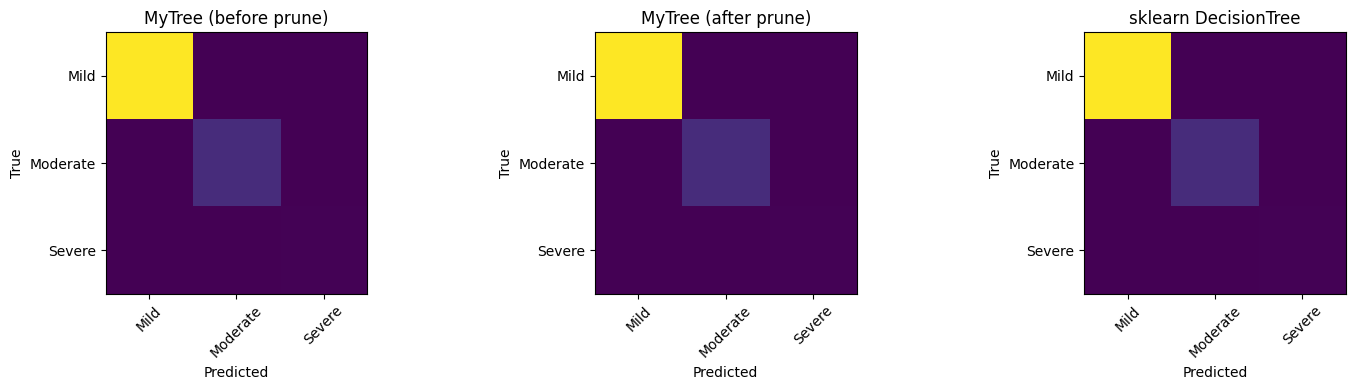

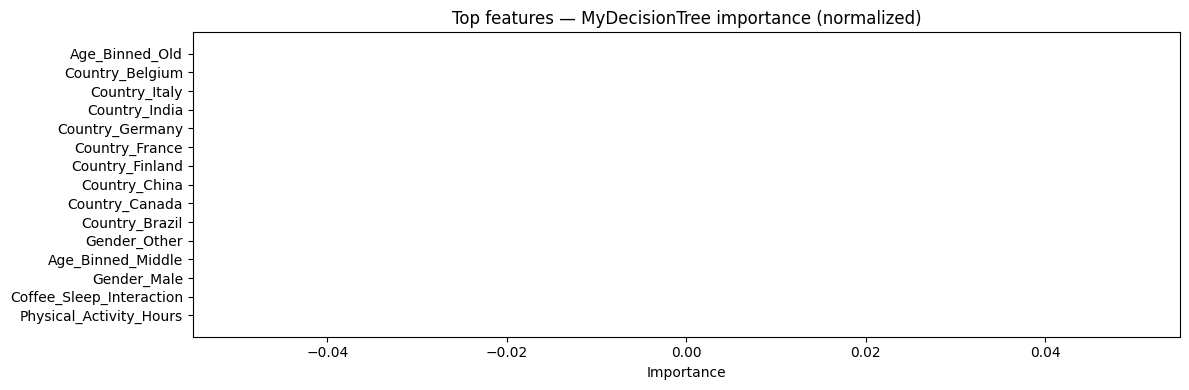

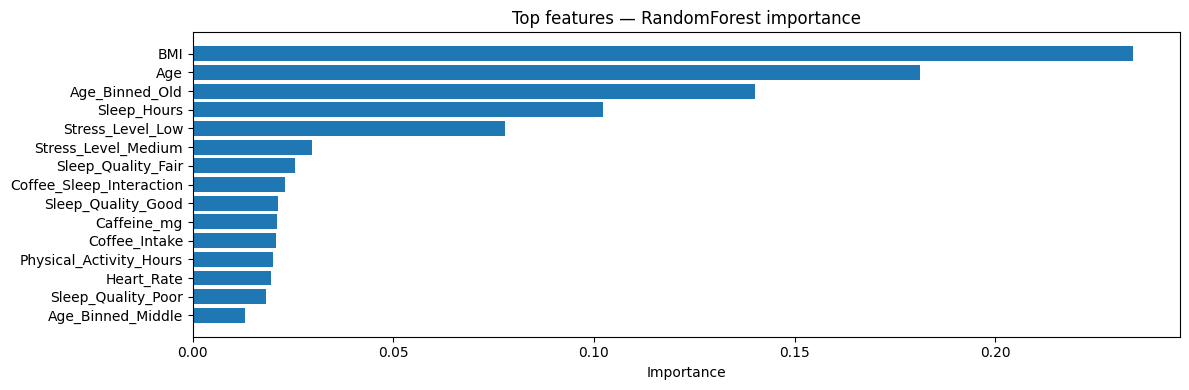

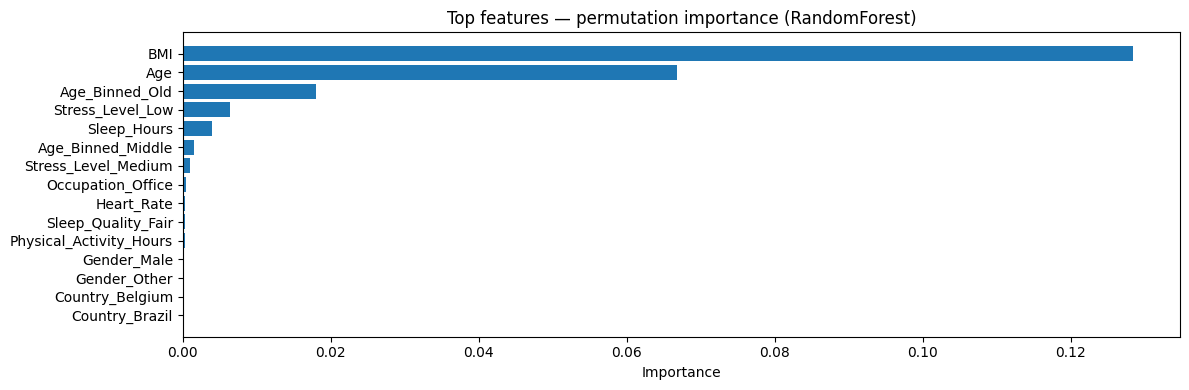

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

# 1. Confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# MyDecisionTree (before pruning)
cm_my_before = confusion_matrix(y_test_enc, pred_test)
axs[0].imshow(cm_my_before, interpolation='nearest')
axs[0].set_title('MyTree (before prune)')

# MyDecisionTree (after pruning)
cm_my_after = confusion_matrix(y_test_enc, pred_test_pruned)
axs[1].imshow(cm_my_after, interpolation='nearest')
axs[1].set_title('MyTree (after prune)')

# sklearn DecisionTree
cm_sk = confusion_matrix(y_test_enc, pred_dt_sk)
axs[2].imshow(cm_sk, interpolation='nearest')
axs[2].set_title('sklearn DecisionTree')

# Настройка осей та підписів
for ax in axs:
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

# 2. Feature importance — MyDecisionTree
feat_names = X_encoded.columns.tolist()
my_imp = tree.feature_importance
top_idx_my = np.argsort(my_imp)[-15:][::-1]

plt.figure(figsize=(12, 4))
plt.barh([feat_names[i] for i in top_idx_my[::-1]], my_imp[top_idx_my[::-1]])
plt.title('Top features — MyDecisionTree importance (normalized)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 3. Feature importance — RandomForest
rf_imp = rf.feature_importances_
top_idx_rf = np.argsort(rf_imp)[-15:][::-1]

plt.figure(figsize=(12, 4))
plt.barh([feat_names[i] for i in top_idx_rf[::-1]], rf_imp[top_idx_rf[::-1]])
plt.title('Top features — RandomForest importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 4. Permutation importance — RandomForest
perm = permutation_importance(rf, X_test, y_test_enc, n_repeats=5, random_state=42)
perm_imp = perm.importances_mean
top_perm_idx = np.argsort(perm_imp)[-15:][::-1]

plt.figure(figsize=(12, 4))
plt.barh([feat_names[i] for i in top_perm_idx[::-1]], perm_imp[top_perm_idx[::-1]])
plt.title('Top features — permutation importance (RandomForest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [16]:
# -----------------------------
# 1. Вибір топ-10 ознак за важливістю MyDecisionTree
# -----------------------------
top10_idx = np.argsort(my_imp)[-10:]
top10 = [feat_names[i] for i in top10_idx]
print("Top-10 features by MyDecisionTree:", top10)

# -----------------------------
# 2. Підготовка вибірок з топ-10 ознаками
# -----------------------------
X_train_sel = X_train[top10]
X_test_sel = X_test[top10]

# -----------------------------
# 3. Навчання sklearn DecisionTree з топ-10 ознаками
# -----------------------------
dt_sk2 = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=8, 
    min_samples_leaf=10, 
    random_state=42
)
dt_sk2.fit(X_train_sel, y_train_enc)
pred_dt2 = dt_sk2.predict(X_test_sel)

# -----------------------------
# 4. Навчання RandomForest з топ-10 ознаками
# -----------------------------
rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf2.fit(X_train_sel, y_train_enc)
pred_rf2 = rf2.predict(X_test_sel)

# -----------------------------
# 5. Обчислення метрик для моделей з топ-10 ознаками
# -----------------------------
metrics2 = [
    compute_metrics(y_test_enc, pred_dt2, 'sklearn DecisionTree (top10)'),
    compute_metrics(y_test_enc, pred_rf2, 'RandomForest (top10)')
]

metrics2_df = pd.DataFrame(metrics2)
print(metrics2_df.to_string(index=False))

Top-10 features by MyDecisionTree: ['Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Finland', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Belgium', 'Age_Binned_Old']
                       model  accuracy  f1_macro  mcc
sklearn DecisionTree (top10)  0.881773  0.312391  0.0
        RandomForest (top10)  0.881773  0.312391  0.0


In [17]:
# Визначення найкращої моделі за F1 (macro)
all_metrics = metrics + metrics2  # об'єднуємо всі метрики, якщо потрібно включити топ-10
best_model = max(all_metrics, key=lambda x: x['f1_macro'])

# Вплив прунінгу
prune_improvement = "покращення" if acc_test_pruned >= accuracy_score(y_test_enc, pred_test) else "немає покращення"

# Топ-10 ознак від MyDecisionTree
top10_features = [feat_names[i] for i in np.argsort(my_imp)[-10:]]
top10_str = ", ".join(top10_features)

# Висновки
print('--- ВИСНОВКИ ---')
print(f"- Найкраща модель: {best_model['model']} (Accuracy: {best_model['accuracy']:.3f}, F1 (macro): {best_model['f1_macro']:.3f}, MCC: {best_model['mcc']:.3f})")
print(f"- Вплив прунінгу: {prune_improvement} (до: {accuracy_score(y_test_enc, pred_test):.3f}, після: {acc_test_pruned:.3f})")

--- ВИСНОВКИ ---
- Найкраща модель: MyDecisionTree (unpruned) (Accuracy: 0.996, F1 (macro): 0.994, MCC: 0.982)
- Вплив прунінгу: покращення (до: 0.996, після: 0.996)
